In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat_ws
from pyspark.sql import functions as F
from scipy.stats import fisher_exact
import numpy as np

In [2]:
spark = SparkSession.builder \
    .appName("drug-to_target_biodata_analysis") \
    .config("spark.jars", "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/22 16:41:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/22 16:41:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Dataset with all datasources
biodata_all = spark.read.parquet("data/analysis/biodata_all_v2")
biodata_all.show()

23/11/22 16:41:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+------------+---------+--------------------+------------------+-------------------+------------+--------+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------

## OR Calculation for Active + GE Vs MoA

In [4]:
# Creating hasGE as boolean
# Define the undesired lists as column expressions for comparison
undesired_chembl = F.array([F.lit('chembl')])
undesired_chemicalProbes = F.array([F.lit('chemicalProbes')])
undesired_both = F.array([F.lit('chembl'), F.lit('chemicalProbes')])
undesired_both_alt = F.array([F.lit('chemicalProbes'), F.lit('chembl')])

# Add the 'hasGE' column
biodata_GE = biodata_all.withColumn(
    'hasGE',
    ~(
        (F.col('sources').isNull()) |
        (F.size(F.col('sources')) == 0) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_chembl)) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_chemicalProbes)) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_both)) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_both_alt))
    )
)
biodata_GE.show()

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+------------+---------+--------------------+------------------+-------------------+------------+--------+-----+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|hasGE|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-----------

In [5]:
# Creating hasGE and Active as boolean
# Define the undesired lists as column expressions for comparison

from pyspark.sql.functions import col

# Assuming your DataFrame is named df
biodata_GE_A = biodata_GE.withColumn('activeAndGE', col('hasGE') & col('isActive'))

biodata_GE_A.show()

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+------------+---------+--------------------+------------------+-------------------+------------+--------+-----+-----------+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|hasGE|activeAndGE|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----

In [6]:
# Creating chemicalProbes as boolean
from pyspark.sql.functions import array_contains, col, coalesce, lit

# Use the array_contains function to check if 'sources' contains 'chemicalProbes'
biodata_GE_prob = biodata_GE_A.withColumn("isProbe", array_contains(coalesce(col("sources"), lit([])), "chemicalProbes"))

biodata_GE_prob.show()

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+------------+---------+--------------------+------------------+-------------------+------------+--------+-----+-----------+-------+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|hasGE|activeAndGE|isProbe|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+----

In [7]:
# 2x2 table for Active Vs MoA
contingency_table_AM = (
    biodata_GE_prob
    .groupBy("isActive", "isMoA")
    .agg(F.count("*").alias("count"))
    .orderBy("isActive", "isMoA")
)

print("Contingency table Active Vs MoA:")
contingency_table_AM.show()
contingency_table_AM_list = contingency_table_AM.collect()

# Extract counts for Fisher's test
a = contingency_table_AM_list[0]['count']  # isActive = False, isMoA = False
b = contingency_table_AM_list[1]['count']  # isActive = False, isMoA = True
c = contingency_table_AM_list[2]['count']  # isActive = True, isMoA = False
d = contingency_table_AM_list[3]['count']  # isActive = True, isMoA = True

# Fisher's Exact Test
_, p_value_AM = fisher_exact([[a, b], [c, d]])

# 3. Compute Odds Ratio and its Confidence Interval
or_ratio_AM = (a * d) / (b * c)
or_lower_AM = np.exp(np.log(or_ratio_AM) - 1.96*np.sqrt(1/a + 1/b + 1/c + 1/d))
or_upper_AM = np.exp(np.log(or_ratio_AM) + 1.96*np.sqrt(1/a + 1/b + 1/c + 1/d))

print(f"Odds Ratio for biodata with GE+: {or_ratio_AM}")
print(f"95% CI: ({or_lower_AM}, {or_upper_AM})")
print(f"P-value: {p_value_AM}")

Contingency table Active Vs MoA:
+--------+-----+-----+
|isActive|isMoA|count|
+--------+-----+-----+
|   false|false|14123|
|   false| true|  426|
|    true|false|12439|
|    true| true| 2720|
+--------+-----+-----+

Odds Ratio for biodata with GE+: 7.249378846706199
95% CI: (6.527227620105087, 8.051426535394084)
P-value: 0.0


In [8]:
# 2x2 table for hasGE Vs MoA
contingency_table_GM = (
    biodata_GE_prob
    .groupBy("hasGE", "isMoA")
    .agg(F.count("*").alias("count"))
    .orderBy("hasGE", "isMoA")
)

print("Contingency table hasGE Vs MoA:")
contingency_table_GM.show()
contingency_table_GM_list = contingency_table_GM.collect()

# Extract counts for Fisher's test
a = contingency_table_GM_list[0]['count']  # isActive = False, isMoA = False
b = contingency_table_GM_list[1]['count']  # isActive = False, isMoA = True
c = contingency_table_GM_list[2]['count']  # isActive = True, isMoA = False
d = contingency_table_GM_list[3]['count']  # isActive = True, isMoA = True

# Fisher's Exact Test
_, p_value_GM = fisher_exact([[a, b], [c, d]])

# 3. Compute Odds Ratio and its Confidence Interval
or_ratio_GM = (a * d) / (b * c)
or_lower_GM = np.exp(np.log(or_ratio_GM) - 1.96*np.sqrt(1/a + 1/b + 1/c + 1/d))
or_upper_GM = np.exp(np.log(or_ratio_GM) + 1.96*np.sqrt(1/a + 1/b + 1/c + 1/d))

print(f"Odds Ratio for biodata with GE+: {or_ratio_GM}")
print(f"95% CI: ({or_lower_GM}, {or_upper_GM})")
print(f"P-value: {p_value_GM}")

Contingency table hasGE Vs MoA:
+-----+-----+-----+
|hasGE|isMoA|count|
+-----+-----+-----+
|false|false|19402|
|false| true| 1164|
| true|false| 7160|
| true| true| 1982|
+-----+-----+-----+

Odds Ratio for biodata with GE+: 4.6140696692199885
95% CI: (4.270898678559492, 4.984814793030051)
P-value: 0.0


In [9]:
# 2x2 table for Active + hasGE Vs MoA
contingency_table_AGM = (
    biodata_GE_prob
    .groupBy("activeAndGE", "isMoA")
    .agg(F.count("*").alias("count"))
    .orderBy("activeAndGE", "isMoA")
)

print("Contingency table hasGE Vs MoA:")
contingency_table_AGM.show()
contingency_table_AGM_list = contingency_table_AGM.collect()

# Extract counts for Fisher's test
a = contingency_table_AGM_list[0]['count']  # isActive = False, isMoA = False
b = contingency_table_AGM_list[1]['count']  # isActive = False, isMoA = True
c = contingency_table_AGM_list[2]['count']  # isActive = True, isMoA = False
d = contingency_table_AGM_list[3]['count']  # isActive = True, isMoA = True

# Fisher's Exact Test
_, p_value_AGM = fisher_exact([[a, b], [c, d]])

# 3. Compute Odds Ratio and its Confidence Interval
or_ratio_AGM = (a * d) / (b * c)
or_lower_AGM = np.exp(np.log(or_ratio_AGM) - 1.96*np.sqrt(1/a + 1/b + 1/c + 1/d))
or_upper_AGM = np.exp(np.log(or_ratio_AGM) + 1.96*np.sqrt(1/a + 1/b + 1/c + 1/d))

print(f"Odds Ratio for biodata with GE+: {or_ratio_AGM}")
print(f"95% CI: ({or_lower_AGM}, {or_upper_AGM})")
print(f"P-value: {p_value_AGM}")

Contingency table hasGE Vs MoA:
+-----------+-----+-----+
|activeAndGE|isMoA|count|
+-----------+-----+-----+
|      false|false|24069|
|      false| true| 1450|
|       true|false| 2493|
|       true| true| 1696|
+-----------+-----+-----+

Odds Ratio for biodata with GE+: 11.292591393833769
95% CI: (10.4104906026308, 12.249434273142008)
P-value: 0.0


In [22]:
import matplotlib.pyplot as plt
import numpy as np

def forest_plot(ORs, CIs, p_values, labels, plot_name="forest_plot", title="Forest Plot", figsize=(10, 6), xlim=(0.1, 10)):
    y_pos = range(len(ORs), 0, -1)

    plt.figure(figsize=figsize)
    plt.axvline(1, color='grey', linestyle='--', linewidth=1)

    # Using black color for points and intervals
    for i, (or_val, (l, u), p_val) in enumerate(zip(ORs, CIs, p_values)):
        plt.plot([l, u], [y_pos[i]]*2, '-', color='black', linewidth=1.5)
        plt.plot(or_val, y_pos[i], 'o', color='black', markersize=6)  # Black points
        plt.plot(l, y_pos[i], marker='|', color='black', markersize=8, mew=2)  # Left tick
        plt.plot(u, y_pos[i], marker='|', color='black', markersize=8, mew=2)  # Right tick

        # Enhanced p-value representation
        if p_val < 0.001:
            plt.text(u + xlim[1]/50, y_pos[i], "p < 0.001", va='center', ha='left', fontsize=9, color='green')
        else:
            exponent = np.ceil(-np.log10(p_val)).astype(int)
            plt.text(u + xlim[1]/50, y_pos[i], f"p = 10^-{exponent}", va='center', ha='left', fontsize=9, color='green')
        
        # Display OR and CI values using the specified blue color
        blue_color = "#135254"
        plt.text(or_val, y_pos[i] + 0.2, f"OR={or_val:.2f} ({l:.2f}, {u:.2f})", ha='center', va='bottom', fontsize=10, color=blue_color)

    plt.yticks(y_pos, labels, fontsize=11)
    plt.xticks(fontsize=10)
    plt.xlabel('Odds Ratio (OR) and 95% Confidence Interval (CI)', fontsize=12)
    plt.title(title, fontsize=15, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines
    plt.tight_layout()
    plt.xlim(xlim)
    plt.ylim(0.5, len(ORs) + 0.5)
    plt.savefig(f"{plot_name}.png", dpi=500)  # Change saving directory if needed
    plt.show()


# Usage:
# forest_plot(ORs, CIs, p_values, labels, "my_forest_plot", "My Custom Plot Title", figsize=(12, 8), xlim=(2, 15))


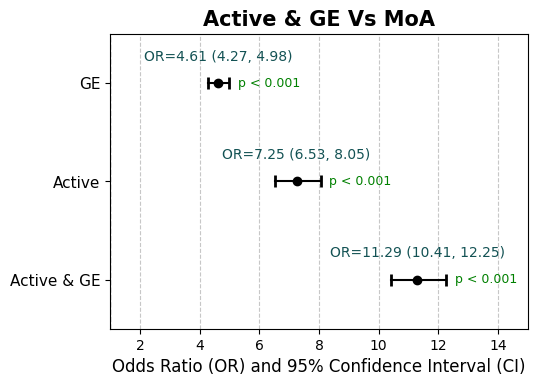

23/11/22 20:05:25 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 944742 ms exceeds timeout 120000 ms
23/11/22 20:05:25 WARN SparkContext: Killing executors is not supported by current scheduler.
23/11/22 20:21:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [23]:
# Sample data
ORs = [or_ratio_GM, or_ratio_AM, or_ratio_AGM]
CIs = [(or_lower_GM, or_upper_GM), (or_lower_AM, or_upper_AM), (or_lower_AGM, or_upper_AGM)]
p_values = [p_value_GM, p_value_AM, p_value_AGM]
labels = ['GE', 'Active', 'Active & GE']

forest_plot(ORs, CIs, p_values, labels, "MoA_v1", "Active & GE Vs MoA", figsize=(6, 4), xlim=(1, 15))

## OR calculation for Active + GE Vs Chemical probes

In [12]:
def get_contingency_counts(contingency_table):
    """
    Extracts counts from a Spark DataFrame that represents a contingency table.
    Assumes the DataFrame has 'count' column and is sorted appropriately.
    """
    contingency_list = contingency_table.collect()
    counts = [row['count'] for row in contingency_list]
    if len(counts) == 4:
        return counts
    else:
        raise ValueError("Contingency table does not have 4 rows.")

In [13]:
def perform_fishers_exact_test(a, b, c, d):
    """
    Performs Fisher's Exact Test and returns the p-value.
    """
    _, p_value = fisher_exact([[a, b], [c, d]])
    return p_value

In [14]:
def compute_odds_ratio_and_ci(a, b, c, d):
    """
    Computes the Odds Ratio and its 95% Confidence Interval.
    """
    or_ratio = (a * d) / (b * c)
    se = np.sqrt(1/a + 1/b + 1/c + 1/d)
    ci_lower = np.exp(np.log(or_ratio) - 1.96 * se)
    ci_upper = np.exp(np.log(or_ratio) + 1.96 * se)
    return or_ratio, ci_lower, ci_upper

In [15]:
# Probes column processing
biodata_GE_prob_t = biodata_GE_prob.withColumn(
    'isHighQualityProbe_true',
    when(col('isHighQualityProbe').isNull(), False).otherwise(col('isHighQualityProbe'))
)

biodata_GE_prob_t.show()

NameError: name 'when' is not defined

In [ ]:
probe = "isHighQualityProbe_true"
# probe = "isProbe"

In [ ]:
# 2x2 table for Active Vs Probes
contingency_table_AP = (
    biodata_GE_prob_t
    .groupBy("isActive", probe)
    .agg(F.count("*").alias("count"))
    .orderBy("isActive", probe)
)

print("Contingency table Active Vs Probes:")
contingency_table_AP.show()

# Extract counts for Fisher's test
a, b, c, d = get_contingency_counts(contingency_table_AP)

# Fisher's Exact Test
p_value_AP = perform_fishers_exact_test(a, b, c, d)

# Compute Odds Ratio and its Confidence Interval
or_ratio_AP, or_lower_AP, or_upper_AP = compute_odds_ratio_and_ci(a, b, c, d)

print(f"Odds Ratio for Active Vs Probes: {or_ratio_AP}")
print(f"95% CI: ({or_lower_AP}, {or_upper_AP})")
print(f"P-value: {p_value_AP}")

Contingency table Active Vs Probes:
+--------+-----------------------+-----+
|isActive|isHighQualityProbe_true|count|
+--------+-----------------------+-----+
|   false|                  false|14464|
|   false|                   true|   85|
|    true|                  false|14422|
|    true|                   true|  737|
+--------+-----------------------+-----+

Odds Ratio for Active Vs Probes: 8.695838873616289
95% CI: (6.938920886448418, 10.897604246155336)
P-value: 5.79457600859566e-128


23/11/07 17:26:15 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 186382 ms exceeds timeout 120000 ms
23/11/07 17:26:15 WARN SparkContext: Killing executors is not supported by current scheduler.
23/11/07 17:26:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [ ]:
# 2x2 table for hasGE Vs Probes
contingency_table_GP = (
    biodata_GE_prob_t
    .groupBy("hasGE", probe)
    .agg(F.count("*").alias("count"))
    .orderBy("hasGE", probe)
)

print("Contingency table hasGE Vs Probes:")
contingency_table_GP.show()

# Extract counts for Fisher's test
a, b, c, d = get_contingency_counts(contingency_table_GP)

# Fisher's Exact Test
p_value_GP = perform_fishers_exact_test(a, b, c, d)

# Compute Odds Ratio and its Confidence Interval
or_ratio_GP, or_lower_GP, or_upper_GP = compute_odds_ratio_and_ci(a, b, c, d)

print(f"Odds Ratio for Active Vs Probes: {or_ratio_GP}")
print(f"95% CI: ({or_lower_GP}, {or_upper_GP})")
print(f"P-value: {p_value_GP}")

Contingency table hasGE Vs Probes:
+-----+-------+-----+
|hasGE|isProbe|count|
+-----+-------+-----+
|false|  false|16422|
|false|   true| 4144|
| true|  false| 8905|
| true|   true|  237|
+-----+-------+-----+

Odds Ratio for Active Vs Probes: 0.10546800309574032
95% CI: (0.09229452662263818, 0.12052176964386416)
P-value: 0.0


In [ ]:
# 2x2 table for Active + hasGE Vs Probes
contingency_table_AGP = (
    biodata_GE_prob_t
    .groupBy("activeAndGE", probe)
    .agg(F.count("*").alias("count"))
    .orderBy("activeAndGE", probe)
)

print("Contingency table hasGE Vs Probes:")
contingency_table_AGP.show()

# Extract counts for Fisher's test
a, b, c, d = get_contingency_counts(contingency_table_AGP)

# Fisher's Exact Test
p_value_AGP = perform_fishers_exact_test(a, b, c, d)

# Compute Odds Ratio and its Confidence Interval
or_ratio_AGP, or_lower_AGP, or_upper_AGP = compute_odds_ratio_and_ci(a, b, c, d)

print(f"Odds Ratio for Active Vs Probes: {or_ratio_AGP}")
print(f"95% CI: ({or_lower_AGP}, {or_upper_AGP})")
print(f"P-value: {p_value_AGP}")

Contingency table hasGE Vs Probes:
+-----------+-------+-----+
|activeAndGE|isProbe|count|
+-----------+-------+-----+
|      false|  false|21354|
|      false|   true| 4165|
|       true|  false| 3973|
|       true|   true|  216|
+-----------+-------+-----+

Odds Ratio for Active Vs Probes: 0.2787400789663965
95% CI: (0.24210565235407458, 0.32091787559162016)
P-value: 8.102003859287857e-98


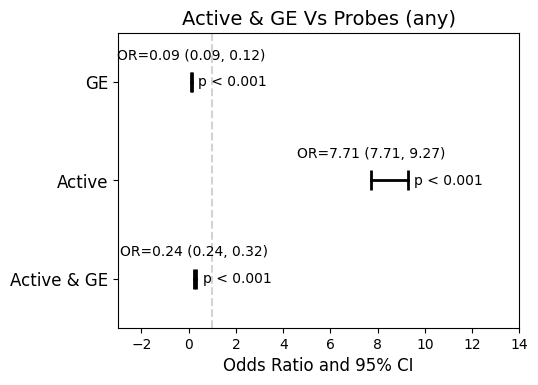

In [ ]:
ORs_probes = [or_lower_GP, or_lower_AP, or_lower_AGP]
CIs_probes = [(or_lower_GP, or_upper_GP), (or_lower_AP, or_upper_AP), (or_lower_AGP, or_upper_AGP)]
p_values_probes = [p_value_GP, p_value_AP, p_value_AGP]
labels_probes = ['GE', 'Active', 'Active & GE']

forest_plot(ORs_probes, CIs_probes, p_values_probes, labels_probes, "Probes_v1", "Active & GE Vs Probes (any)", figsize=(6, 4), xlim=(-3, 14))

### Aggregate evidence by source type

In [ ]:
from pyspark.sql.functions import explode, col

unique_values_df = biodata_GE_prob.withColumn("exploded_sources", explode(col("sources"))) \
                     .select("exploded_sources") \
                     .distinct()

# To show the unique values you can do
unique_values_df.show()


+------------------+
|  exploded_sources|
+------------------+
|  uniprot_variants|
|       gene_burden|
|    chemicalProbes|
|            chembl|
|           intogen|
|          orphanet|
|cancer_gene_census|
|           clingen|
|               eva|
|    gene2phenotype|
|uniprot_literature|
|       eva_somatic|
|ot_genetics_portal|
|              impc|
+------------------+



In [ ]:
from functools import reduce
from pyspark.sql import functions as F
from pyspark.sql.functions import col, array_contains, when

rare_mendelian = ['uniprot_variants', 'clingen', 'gene2phenotype', 'orphanet', 'eva', 'uniprot_literature']
common_disease = ['gene_burden', 'ot_genetics_portal']
chemicalProbes = ['chemicalProbes']
literature = ['chembl']
somatic = ['intogen', 'cancer_gene_census', 'eva_somatic']
mouse_model = ['impc']

# A dictionary to hold the category and its corresponding list
categories = {
    'Rare_mendelian': rare_mendelian,
    'Common_disease': common_disease,
    'ChemicalProbes': chemicalProbes,
    'Literature': literature,
    'Somatic': somatic,
    'Mouse_model': mouse_model
}

# Loop through the dictionary to create a new boolean column for each category
for category, values_to_check in categories.items():
    # Create a condition for each value in the list
    condition = reduce(lambda x, y: x | y, (array_contains(col("sources"), v) for v in values_to_check))
    # Add a new column to the DataFrame based on the condition
    biodata_GE_prob = biodata_GE_prob.withColumn(category, when(condition, True).otherwise(False))

# Show the updated DataFrame
biodata_GE_prob.show()


+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+------------+---------+--------------------+------------------+-------------------+------------+--------+-----+-----------+-------+--------------+--------------+--------------+----------+-------+-----------+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|hasGE|activeAndGE|isProbe|Rare_mendelian|Common_disease|ChemicalProbes|Literature|Somatic|Mouse_model|
+---------+------------+--------+---------------+-

In [ ]:
ORs = []
CIs = []
p_values = []
labels = []

biodata_source = biodata_GE_prob

In [ ]:
# Categories you have a boolean column for
category_columns = ['Rare_mendelian', 'Common_disease', 'ChemicalProbes', 'Somatic', 'Mouse_model']

# Iterate over each category to perform analysis and collect results
for category in category_columns:
    # Perform the groupBy operation for the current category
    contingency_table = (
        biodata_source
        .groupBy(category, "isMoA")
        .agg(F.count("*").alias("count"))
        .orderBy(category, "isMoA")
    )

    # Convert DataFrame to list for processing with Fisher's test
    contingency_table_list = contingency_table.collect()

    # Extract counts for Fisher's test (assuming the order of rows corresponds to False/False, False/True, True/False, True/True)
    a = contingency_table_list[0]['count']
    b = contingency_table_list[1]['count']
    c = contingency_table_list[2]['count']
    d = contingency_table_list[3]['count']

    # Perform Fisher's Exact Test
    p_value = fisher_exact([[a, b], [c, d]])[1]

    # Compute Odds Ratio and its Confidence Interval
    or_ratio = (d * a) / (b * c) if b * c != 0 else float('inf')  # Adjust based on your definition
    or_lower, or_upper = np.exp(np.log(or_ratio) + np.array([-1, 1]) * 1.96 * np.sqrt(1/a + 1/b + 1/c + 1/d)) if or_ratio != float('inf') else (0, float('inf'))

    # Store results
    ORs.append(or_ratio)
    CIs.append((or_lower, or_upper))
    p_values.append(p_value)
    labels.append(category)


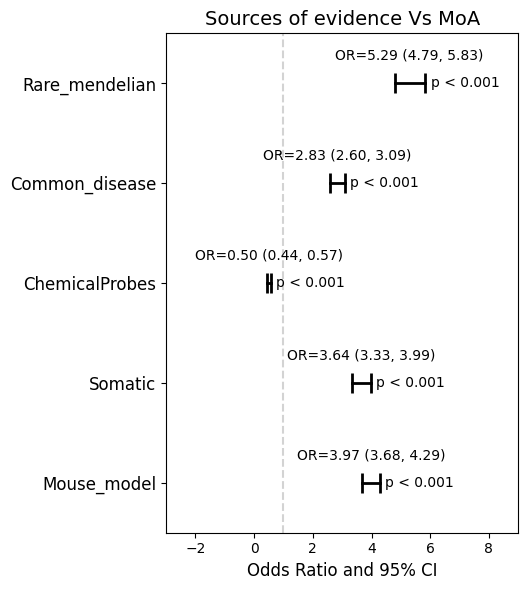

In [ ]:
forest_plot(ORs, CIs, p_values, labels, "MoA_source_v1", "Sources of evidence Vs MoA", figsize=(6, 6), xlim=(-3, 9))

In [ ]:
# 2x2 table for Literature Vs isMoA
contingency_Literature = (
    biodata_source
    .groupBy("Literature", "isMoA")
    .agg(F.count("*").alias("count"))
    .orderBy("Literature", "isMoA")
)

print("Contingency table Literature Vs isMoA:")
contingency_Literature.show()

# Extract counts for Fisher's test
a, b, c, d = get_contingency_counts(contingency_Literature)

# Fisher's Exact Test
p_value_Literature = perform_fishers_exact_test(a, b, c, d)

# Compute Odds Ratio and its Confidence Interval
or_ratio_Literature, or_lower_Literature, or_upper_Literature = compute_odds_ratio_and_ci(a, b, c, d)

print(f"Odds Ratio for Active Vs Probes: {or_ratio_Literature:.1f}")
print(f"95% CI: ({or_lower_Literature:.1f}, {or_upper_Literature:.1f})")
print(f"P-value: {p_value_Literature:.0e}")




Contingency table Literature Vs isMoA:
+----------+-----+-----+
|Literature|isMoA|count|
+----------+-----+-----+
|     false|false|19099|
|     false| true|    8|
|      true|false| 7463|
|      true| true| 3138|
+----------+-----+-----+

Odds Ratio for Active Vs Probes: 1003.8
95% CI: (501.3, 2010.1)
P-value: 0e+00


### Create contingency table for biodata_all regardless source of evidence

In [ ]:
contingency_table_all = (
    biodata_all
    .groupBy("isActive", "isMoA")
    .agg(F.count("*").alias("count"))
    .orderBy("isActive", "isMoA")
)

print("Contingency table regardless source of evidence:")
contingency_table_all.show()
contingency_table_all_list = contingency_table_all.collect()

Contingency table regardless source of evidence:
+--------+-----+-----+
|isActive|isMoA|count|
+--------+-----+-----+
|   false|false|14123|
|   false| true|  426|
|    true|false|12439|
|    true| true| 2720|
+--------+-----+-----+



### Create contingency table for biodata_all for source of evidence = GE_plus




In [ ]:
# Define a new column 'isGE_plus' based on the contents of 'sources'
biodata_GE_plus = biodata_all.withColumn(
    'isGE_plus',
    F.when((F.col('sources').isNull()) | (F.size(F.col('sources')) == 0), F.lit(False))
    .otherwise(F.lit(True))
)
biodata_GE_plus.show()

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+------------+---------+--------------------+------------------+-------------------+------------+--------+---------+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|isGE_plus|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+---

In [ ]:
# Filter the DataFrame where 'isGE_plus' is True
biodata_GE_plus_t = biodata_GE_plus.filter(F.col('isGE_plus'))

# Now create the contingency table for the subset where 'isGE_plus' is True
contingency_table_GE_plus_t = (
    biodata_GE_plus_t
    .groupBy("isActive", "isMoA")
    .agg(F.count("*").alias("count"))
    .orderBy("isActive", "isMoA")
)

print("Contingency table for source of evidence = GE_plus:")
contingency_table_GE_plus_t.show()
contingency_table_GE_plus_t_list = contingency_table_GE_plus_t.collect()

Contingency table for source of evidence = GE_plus:
+--------+-----+-----+
|isActive|isMoA|count|
+--------+-----+-----+
|   false|false| 6714|
|   false| true|  425|
|    true|false| 7630|
|    true| true| 2718|
+--------+-----+-----+



In [ ]:
# Filter the DataFrame for rows where 'isGE_plus' is False
biodata_GE_plus_f = biodata_GE_plus.filter(~F.col('isGE_plus'))

# Now create the contingency table for the subset where 'isGE_plus' is True
contingency_table_GE_plus_f = (
    biodata_GE_plus_f
    .groupBy("isActive", "isMoA")
    .agg(F.count("*").alias("count"))
    .orderBy("isActive", "isMoA")
)

print("Contingency table for source of evidence != GE_plus:")
contingency_table_GE_plus_f.show()
contingency_table_GE_plus_f_list = contingency_table_GE_plus_f.collect()

Contingency table for source of evidence != GE_plus:
+--------+-----+-----+
|isActive|isMoA|count|
+--------+-----+-----+
|   false|false| 7409|
|   false| true|    1|
|    true|false| 4809|
|    true| true|    2|
+--------+-----+-----+



In [ ]:
# 3rd dimention to GE_plus
three_way_table_GE_plus = (
    biodata_GE_plus
    .groupBy("isActive", "isMoA", "isGE_plus")
    .agg(F.count("*").alias("count"))
    .orderBy("isActive", "isMoA", "isGE_plus")
)

# Show the resulting DataFrame
three_way_table_GE_plus.show()

+--------+-----+---------+-----+
|isActive|isMoA|isGE_plus|count|
+--------+-----+---------+-----+
|   false|false|    false| 7409|
|   false|false|     true| 6714|
|   false| true|    false|    1|
|   false| true|     true|  425|
|    true|false|    false| 4809|
|    true|false|     true| 7630|
|    true| true|    false|    2|
|    true| true|     true| 2718|
+--------+-----+---------+-----+



In [ ]:
pandas_df_plus = three_way_table_GE_plus.toPandas()
pandas_df_plus.to_csv("analysis/three_way_table_GE_plus.csv", index=False)

### Create contingency table for biodata_all for source of evidence = GE

In [ ]:
# Define the undesired lists as column expressions for comparison
undesired_chembl = F.array([F.lit('chembl')])
undesired_chemicalProbes = F.array([F.lit('chemicalProbes')])
undesired_both = F.array([F.lit('chembl'), F.lit('chemicalProbes')])
undesired_both_alt = F.array([F.lit('chemicalProbes'), F.lit('chembl')])

# Assuming biodata_all is your DataFrame
# Add the 'isGE' column
biodata_GE = biodata_all.withColumn(
    'isGE',
    ~(
        (F.col('sources').isNull()) |
        (F.size(F.col('sources')) == 0) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_chembl)) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_chemicalProbes)) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_both)) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_both_alt))
    )
)
biodata_GE.show()

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+------------+---------+--------------------+------------------+-------------------+------------+--------+-----+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive| isGE|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-----------

In [ ]:
# Filter the DataFrame where 'isGE_plus' is True
biodata_GE_t = biodata_GE.filter(F.col('isGE'))

# Now create the contingency table for the subset where 'isGE' is True
contingency_table_GE_t = (
    biodata_GE_t
    .groupBy("isActive", "isMoA")
    .agg(F.count("*").alias("count"))
    .orderBy("isActive", "isMoA")
)

print("Contingency table for source of evidence = GE:")
contingency_table_GE_t.show()
contingency_table_GE_t_list = contingency_table_GE_t.collect()

Contingency table for source of evidence = GE:
+--------+-----+-----+
|isActive|isMoA|count|
+--------+-----+-----+
|   false|false| 4667|
|   false| true|  286|
|    true|false| 2493|
|    true| true| 1696|
+--------+-----+-----+



In [ ]:
# Filter the DataFrame where 'isGE_plus' is True
biodata_GE_f = biodata_GE.filter(~F.col('isGE'))

# Now create the contingency table for the subset where 'isGE' is True
contingency_table_GE_f = (
    biodata_GE_f
    .groupBy("isActive", "isMoA")
    .agg(F.count("*").alias("count"))
    .orderBy("isActive", "isMoA")
)

print("Contingency table for source of evidence != GE:")
contingency_table_GE_f.show()
contingency_table_GE_f_list = contingency_table_GE_f.collect()

Contingency table for source of evidence != GE:
+--------+-----+-----+
|isActive|isMoA|count|
+--------+-----+-----+
|   false|false| 9456|
|   false| true|  140|
|    true|false| 9946|
|    true| true| 1024|
+--------+-----+-----+



In [ ]:
# 3rd dimention to GE_plus
three_way_table_GE = (
    biodata_GE
    .groupBy("isActive", "isMoA", "isGE")
    .agg(F.count("*").alias("count"))
    .orderBy("isActive", "isMoA", "isGE")
)

# Show the resulting DataFrame
three_way_table_GE.show()

+--------+-----+-----+-----+
|isActive|isMoA| isGE|count|
+--------+-----+-----+-----+
|   false|false|false| 9456|
|   false|false| true| 4667|
|   false| true|false|  140|
|   false| true| true|  286|
|    true|false|false| 9946|
|    true|false| true| 2493|
|    true| true|false| 1024|
|    true| true| true| 1696|
+--------+-----+-----+-----+



In [ ]:
pandas_df = three_way_table_GE.toPandas()
pandas_df.to_csv("analysis/three_way_table_GE.csv", index=False)